In [1]:
# Credits:
# This notebook has small modifications to Elvis Murina's notebook:
#     https://github.com/tensorchiefs/dl_course_2018/blob/master/notebooks/12_LSTM_vs_1DConv_solution.ipynb
# Images are adopted from Beate, Oliver, and Elvis's book:
#     Probabilistic Deep Learning  
#     With Python, Keras and TensorFlow Probability
#     Oliver Dürr, Beate Sick, Elvis Murina
#     MEAP began June 2019  Publication in Fall 2020 (estimated)
#     ISBN 9781617296079  252 pages (estimated)  printed in black & white  
# and from Jurgen Schmidhuber's tutorial 
#      http://people.idsia.ch/~juergen/lstm/sld016.htm

# Prediction of periodic signal with different neural networks architectures

Here compare 1D convolutional neural networks (CNN) with and without dilation rate to recurrent neural networks (RNNs), a simple RNN and a long short-term memory (LSTM) RNN


## Neural network (NN) architectures

### Feed forward NN

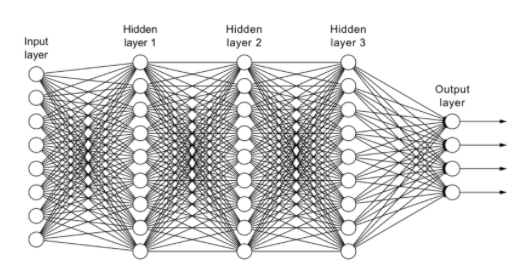

### Convolutional NN

* Illustration of complex CNN architecture: 3 convolutional (with several feature maps each) and 3 fully connected layers

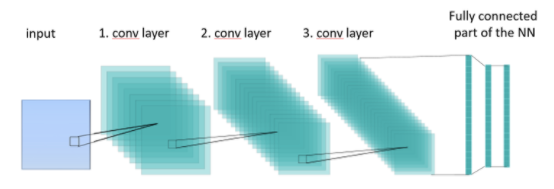

* Example of 1-D convolution with a kernel = [1, 2]

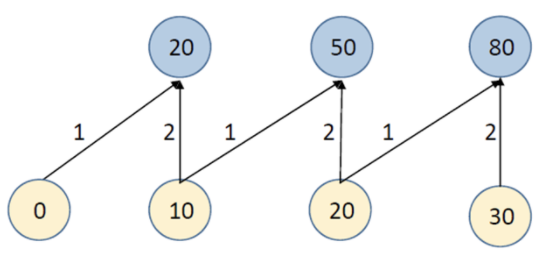

### Recurrent NN

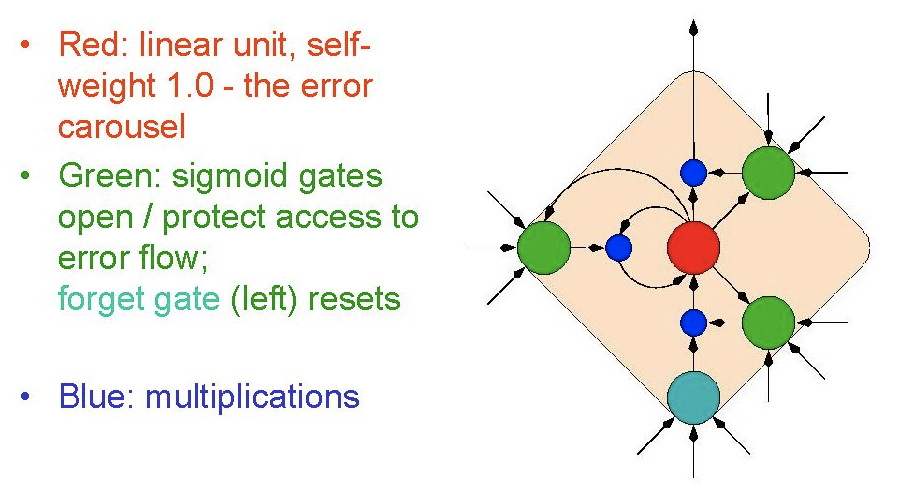

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN

2023-02-15 15:32:10.406979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Simulate periodic signal

* Generate a periodic signal as: 
```
fast sine wave * slow sine wave + random noise
````


/var/folders/dy/8dn90jpn69n2ll8zbnrsfwn00000gp/T/ipykernel_46956/2383354559.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'b-',color='orange')


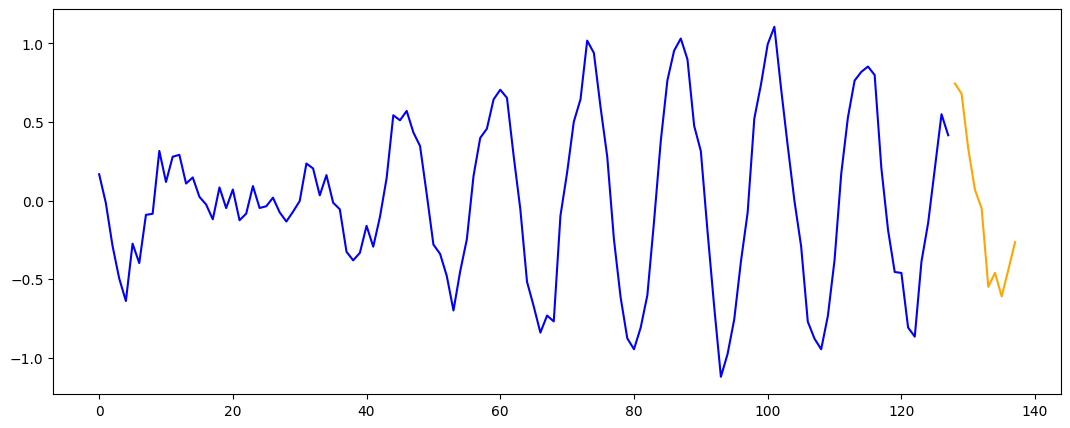

The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.


In [3]:
np.random.seed(1) # Fixing the seed, so data generation is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1,seq_length=128,look_ahead=10): # We create 1000 observations of the process
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.figure(num=None, figsize=(13,5))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'b-',color='orange')

plt.show()
print('The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.')

### Components of the signal we generated

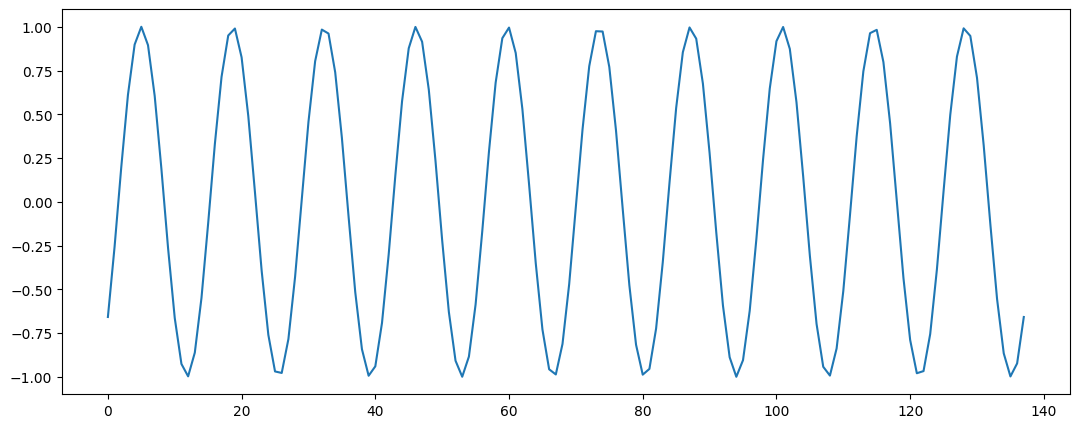

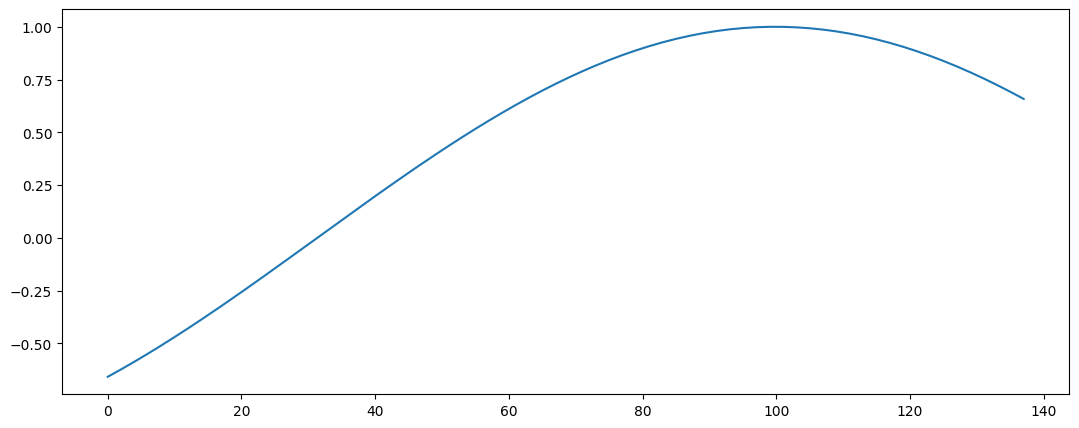

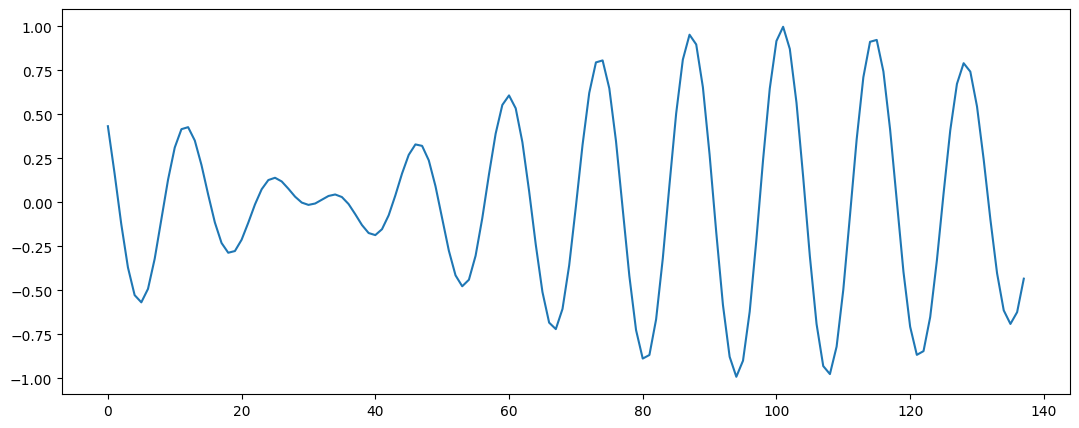

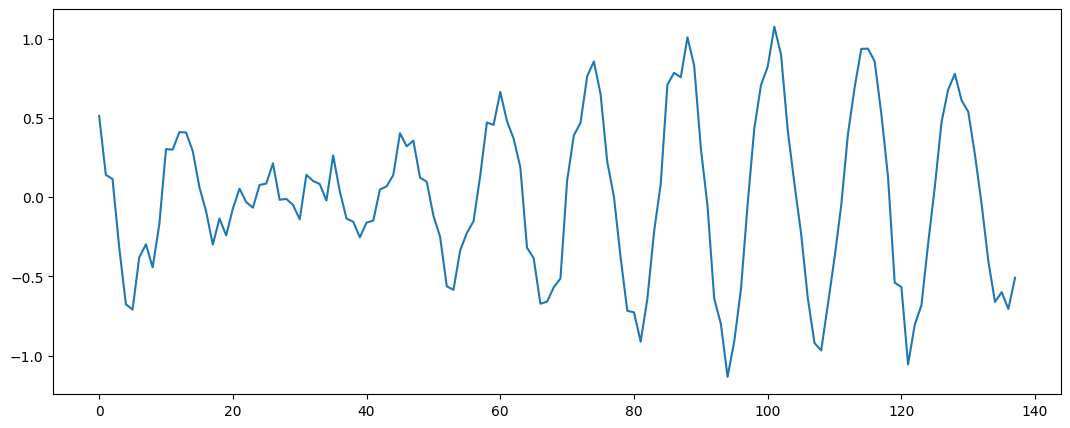

In [4]:
start = np.random.uniform(0, 2*np.pi) # Random start point
s=128+10
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s))+np.random.normal(0,0.1,s))
plt.show()


# Build NN models, train, and predict

## CNNs

### 1D Convolution without dilation rate

Here we define a Neural network with 1D convolutions and "causal" padding, in a later step we will also use a dilation rate.

In [5]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]
  
model_1Dconv = Sequential()
ks = 5
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', input_shape=(128, 1)))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Dense(1))
model_1Dconv.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_1Dconv.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 32)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 32)           5152      
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 32)           5152      
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 32)           5152      
                                                                 
 dense (Dense)               (None, 128, 1)            33        
                                                                 
 lambda (Lambda)             (None, 10, 1)             0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-traina

2023-02-15 15:32:28.978260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
history = model_1Dconv.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Epoch 1/100
7/7 [==============================] - 2s 66ms/step - loss: 0.1069 - val_loss: 0.0429
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0485 - val_loss: 0.0471
Epoch 3/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0414 - val_loss: 0.0424
Epoch 4/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0389 - val_loss: 0.0321
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0359 - val_loss: 0.0297
Epoch 6/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0326 - val_loss: 0.0292
Epoch 7/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0308 - val_loss: 0.0269
Epoch 8/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0294 - val_loss: 0.0260
Epoch 9/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0280 - val_loss: 0.0246
Epoch 10/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0267 - val_loss: 0.0238
Epoch 11/100
7/7 [=

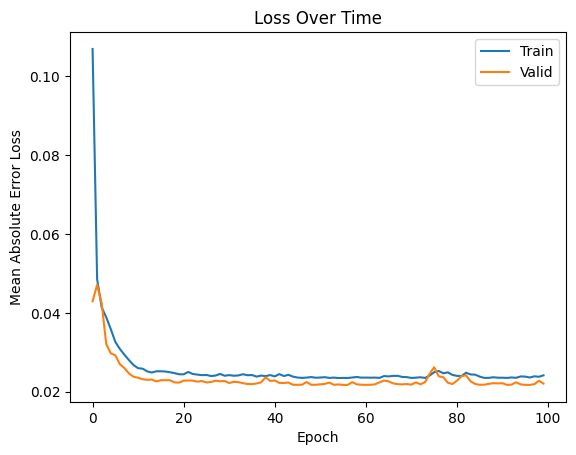

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid']);

Now we want to use the trained model to predict for the next 10 steps, remember that is what the model was trained on.  
In addition,  we want to predict for longer than just 10 steps, we will  just predict the next 10 steps and take the predictions as new "true" observations and feed these values into the model, when we do that we can predict for any length we want. In the next cell we will predict the next 10 and 80 steps.

1/1 [==============================] - 0s 17ms/step


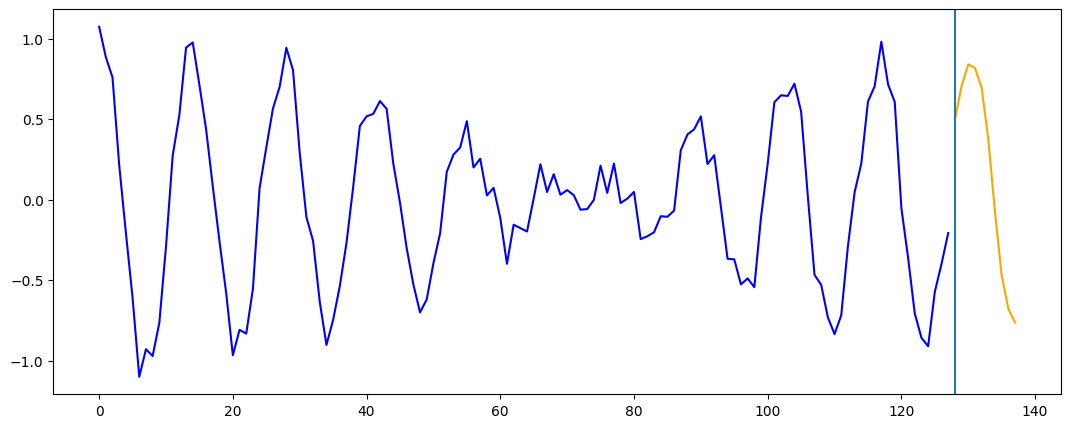

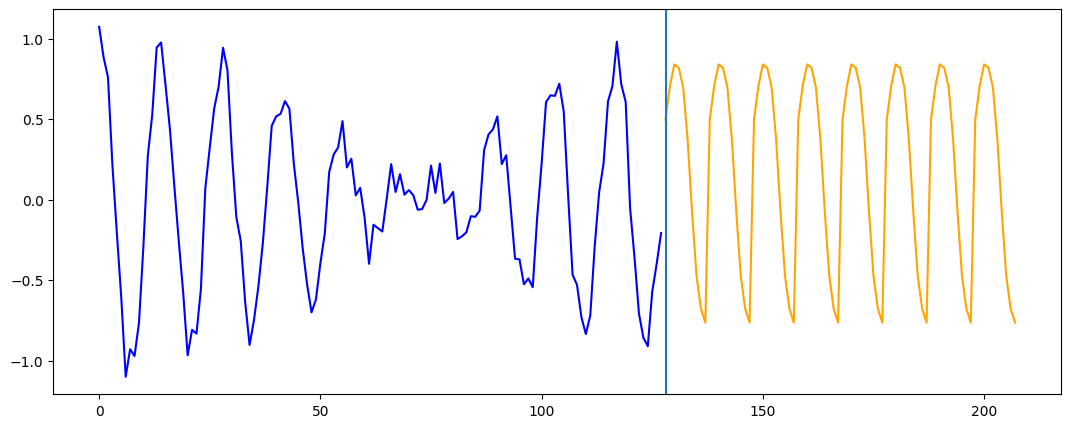

In [8]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0].reshape(10)
  pred=np.append(pred,res)
    
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0].reshape(10)
  pred=np.append(pred,res)

plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time.

In [9]:
model_1Dconv_w_d = Sequential()
ks = 5
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1, input_shape=(128, 1)))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))
model_1Dconv_w_d.add(Dense(1))
model_1Dconv_w_d.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_1Dconv_w_d.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv_w_d.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 128, 32)           192       
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 32)           5152      
                                                                 
 conv1d_6 (Conv1D)           (None, 128, 32)           5152      
                                                                 
 conv1d_7 (Conv1D)           (None, 128, 32)           5152      
                                                                 
 dense_1 (Dense)             (None, 128, 1)            33        
                                                                 
 lambda_1 (Lambda)           (None, 10, 1)             0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-trai

In [10]:
history = model_1Dconv_w_d.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Epoch 1/100
7/7 [==============================] - 2s 85ms/step - loss: 0.1326 - val_loss: 0.0510
Epoch 2/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0418 - val_loss: 0.0244
Epoch 3/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0219 - val_loss: 0.0157
Epoch 4/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0155 - val_loss: 0.0157
Epoch 5/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0153 - val_loss: 0.0132
Epoch 6/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0137 - val_loss: 0.0132
Epoch 7/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0131 - val_loss: 0.0121
Epoch 8/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 9/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 10/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 11/100
7/7 [=

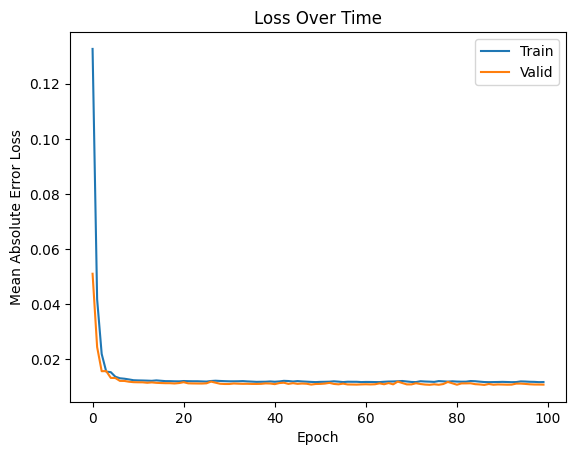

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

1/1 [==============================] - 0s 17ms/step


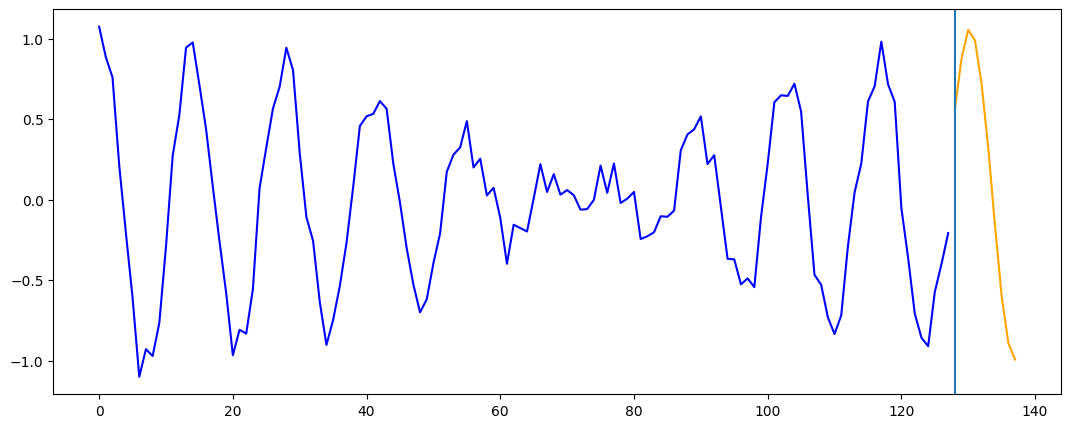

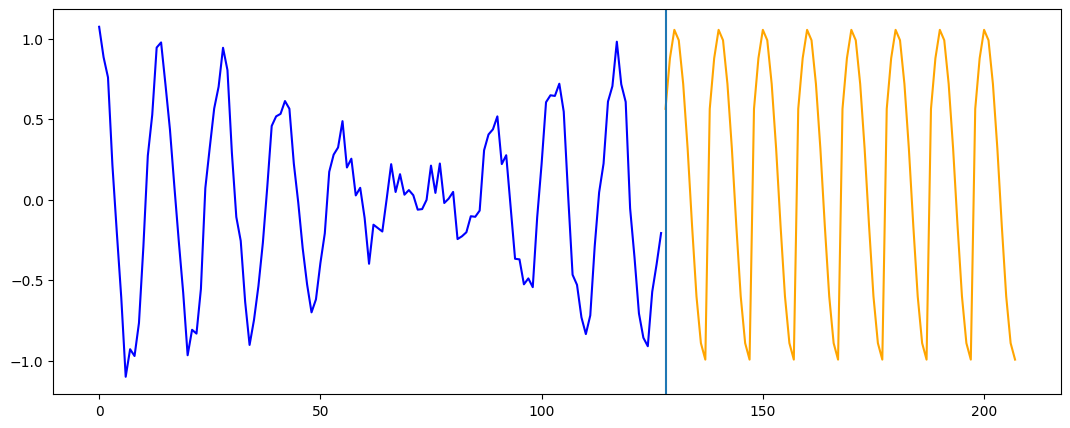

In [12]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0].reshape(10)
  pred=np.append(pred,res)

plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  pred=np.append(pred,res)

plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

## RNNs

### Simple RNN

Now, let's use a RNN cell to see if we are able to learn the data generating process. We will use a hidden state size of 12.

In [13]:
model_simple_RNN = Sequential()

model_simple_RNN.add(SimpleRNN(12,return_sequences=True,input_shape=(128,1)))

model_simple_RNN.add((Dense(1)))
model_simple_RNN.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_simple_RNN.summary()
model_simple_RNN.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128, 12)           168       
                                                                 
 dense_2 (Dense)             (None, 128, 1)            13        
                                                                 
 lambda_2 (Lambda)           (None, 10, 1)             0         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model_simple_RNN.fit(X[0:800], Y[0:800],
                    epochs=500,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=0)

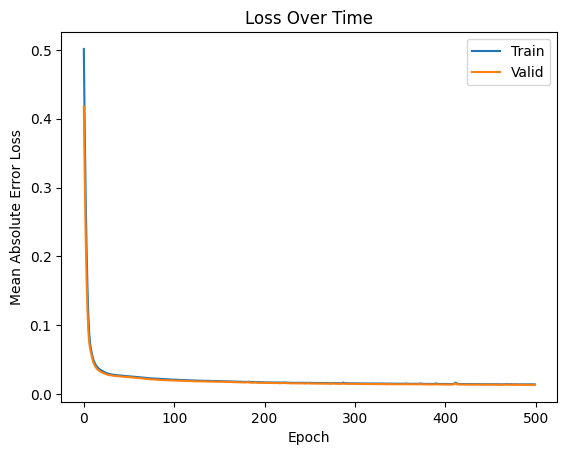

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

1/1 [==============================] - 0s 20ms/step


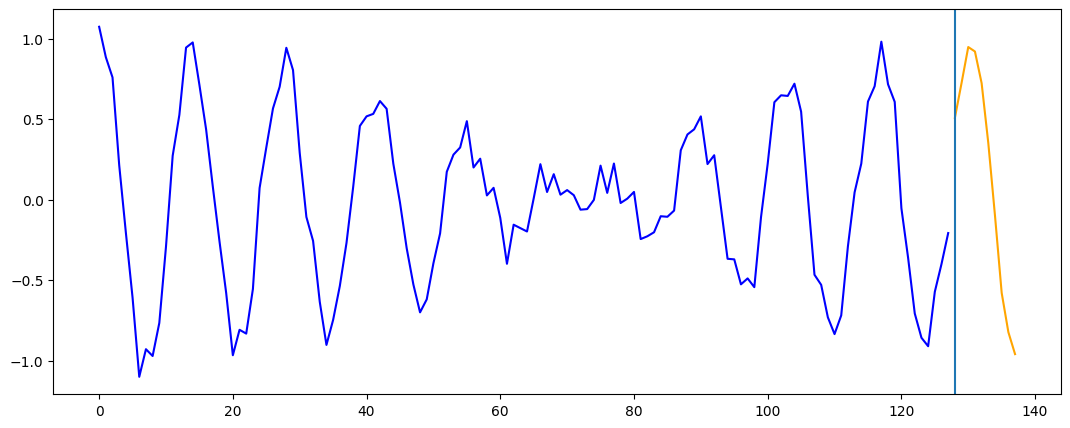

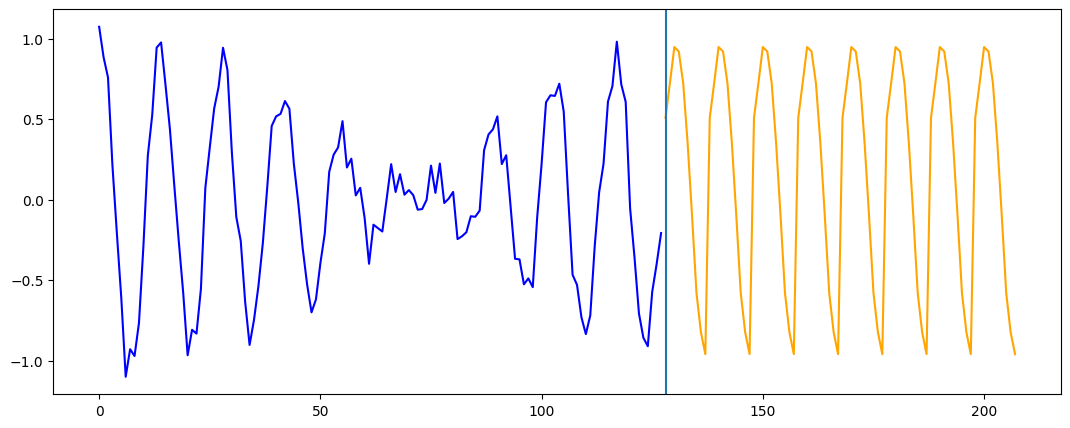

In [16]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_RNN

for j in range(0,steps):
  res = model.predict(data)[0].reshape(10)
  pred=np.append(pred,res)
    
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_RNN

for j in range(0,steps):
  res = model.predict(data)[0].reshape(10)
  pred=np.append(pred,res)

plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### LSTM Cell

Let's use a more complex LSTM cell to and see if it works better than the RNN cell,  we again use a hidden state size of 12.

In [17]:
model_LSTM = Sequential()

model_LSTM.add(LSTM(12,return_sequences=True,input_shape=(128,1)))
model_LSTM.add((Dense(1)))
model_LSTM.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_LSTM.summary()
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 12)           672       
                                                                 
 dense_3 (Dense)             (None, 128, 1)            13        
                                                                 
 lambda_3 (Lambda)           (None, 10, 1)             0         
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [18]:
# takes a couple of minutes
history = model_LSTM.fit(X[0:800], Y[0:800],
                    epochs=1000,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=0)
#save model
#model_LSTM.save('../data/models/lstm_model_500_epochs.hdf5')  

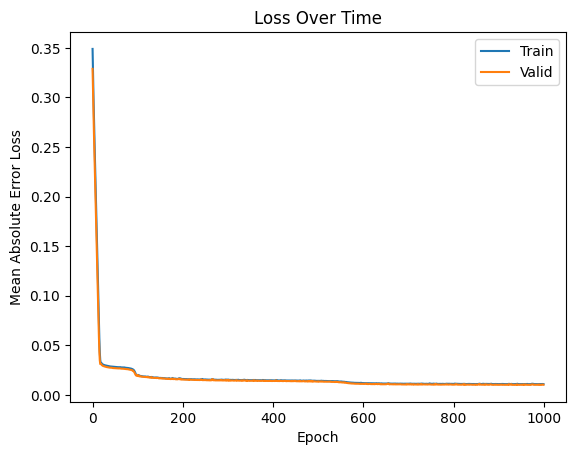

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

1/1 [==============================] - 0s 22ms/step


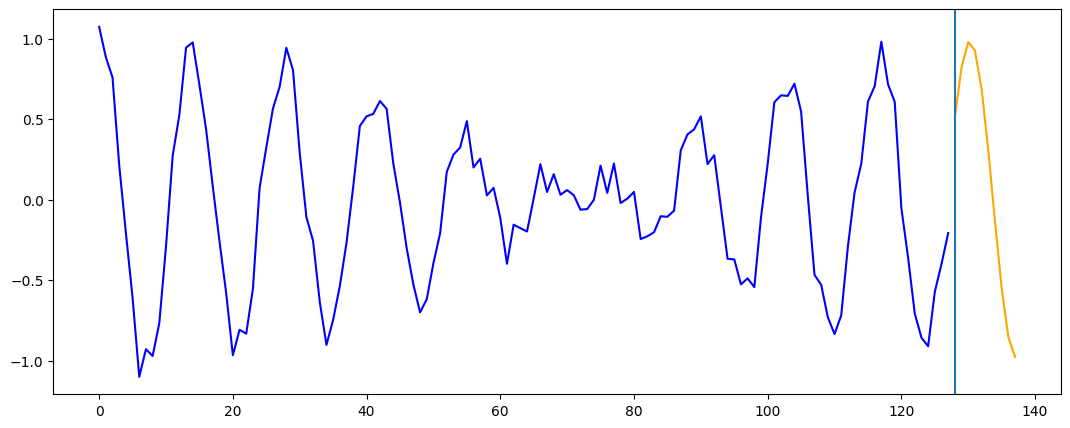

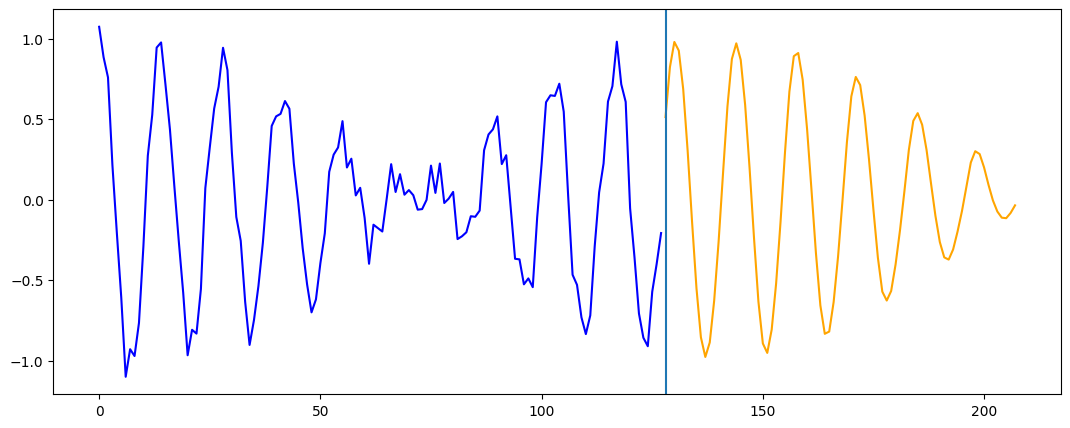

In [20]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_LSTM

for j in range(0,steps):
  res = model.predict(data)[0].reshape(10)
  pred=np.append(pred,res)

plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



# Compare all models for very long predictions

1/1 [==============================] - 0s 22ms/step


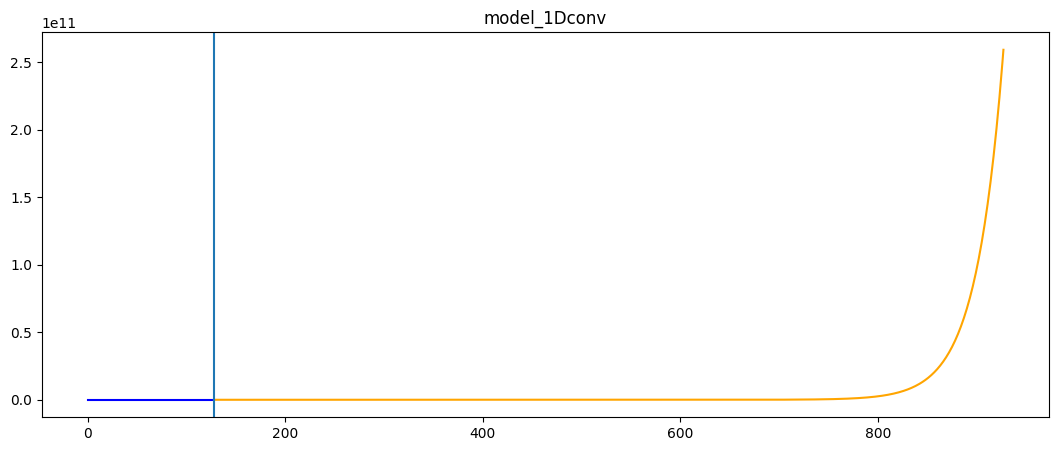

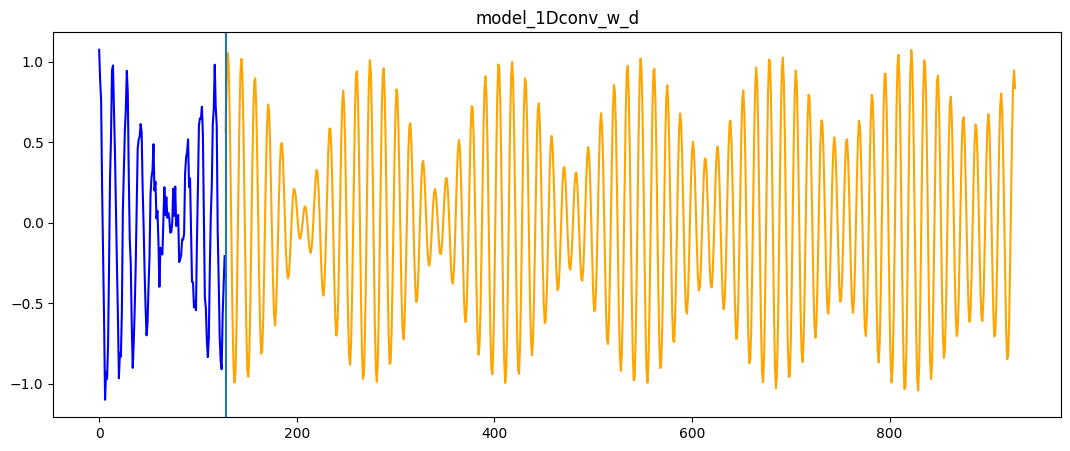

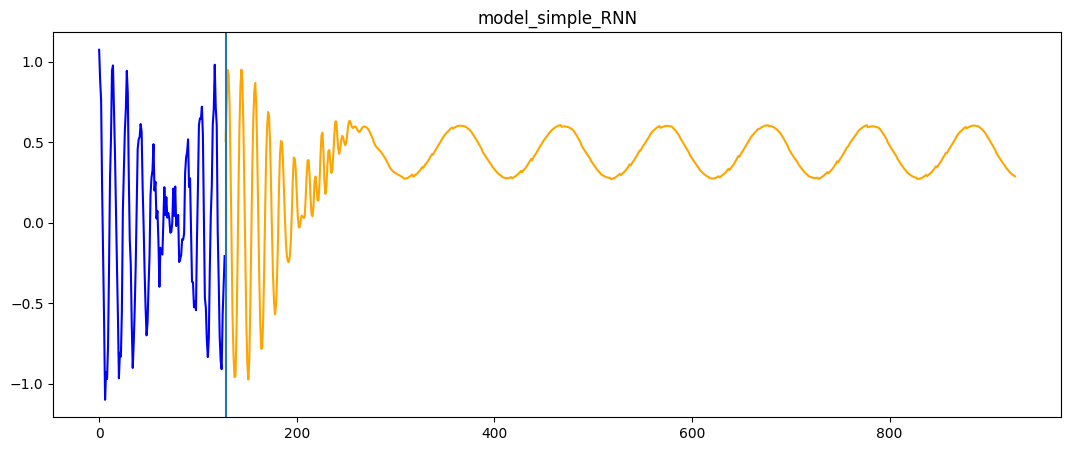

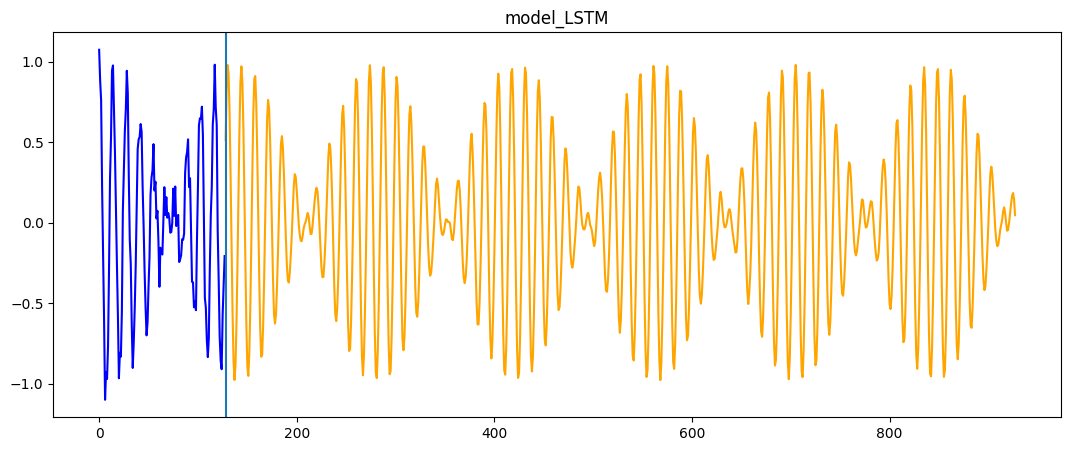

In [21]:
i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_1Dconv")

i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_1Dconv_w_d")

i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_RNN

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_simple_RNN")

i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_LSTM");
